In [4]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *



In [5]:
band = 'i'
## Luminosity function parameters
alpha = -1
Ms = -22

In [208]:
########################################################
def LFfunction(M, Ms, alpha):
    dm = 0.4*(Ms-M)
    c = 10.**dm
    b = c**(alpha+1)
    
    return b/np.exp(c)

<ipython-input-210-327a23644344>:10: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


Text(0, 0.5, 'Number')

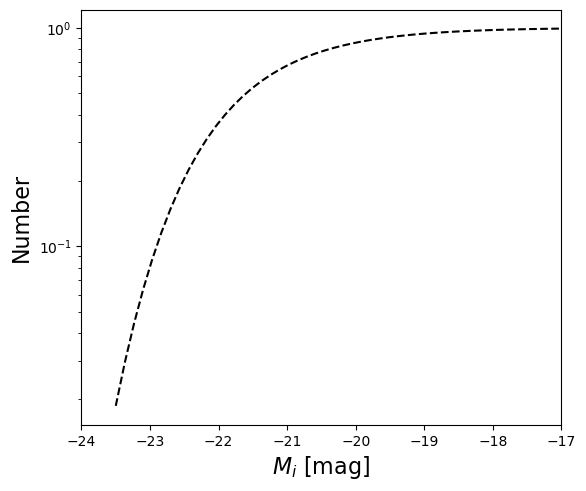

In [210]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M,N,'k--')

ax.set_yscale("log", nonposy='clip')

ax.set_xlabel(r'$M_{i}$'+' [mag]', fontsize=16)
ax.set_ylabel('Number', fontsize=16)

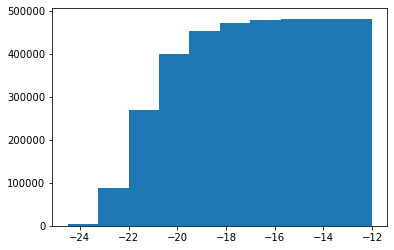

In [278]:
np.random.seed(0)

size = 5000000
randMGAG = np.random.uniform(low=-25, high=-12, size=size)

randU = np.random.uniform(low=0, high=1, size=size)

randLfunct = LFfunction(randMGAG, Ms, alpha)

indx, = np.where(randU<randLfunct)

simulMag  = randMGAG[indx]

plt.hist(simulMag)


scatterMAG = simulMag + np.random.normal(0, 0.5, len(simulMag))

In [279]:
np.std(np.random.normal(0, 0.5, len(simulMag)))

0.5000338072009847

In [280]:
def Normal(x, mu, sigma):
    y = np.exp(-(x-mu)**2/(2.*sigma**2))
    return y/sigma/np.sqrt(2.*np.pi)

In [281]:
Mo_lst = []
Ma_lst = []

for Mo in np.linspace(-25,-14,1000):
    
    ind, = np.where((scatterMAG>Mo-0.1)&(scatterMAG<Mo+0.1))
    Mo_lst.append(np.mean(scatterMAG[ind]))
    Ma_lst.append(np.mean(simulMag[ind]))

#     Mo_lst.append(Mo)  # what we see
    
#     weights = Normal(simulMag, Mo, 0.2)  
#     Ma_av = np.sum(simulMag*weights)/np.sum(weights) 
#     Ma_lst.append(Ma_av)  # what really is
    
Mo_lst = np.asarray(Mo_lst)
Ma_lst = np.asarray(Ma_lst)

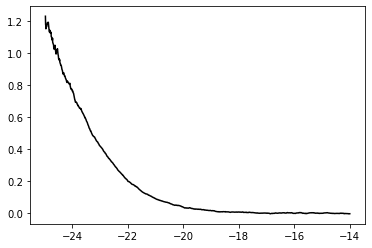

In [282]:
plt.plot(Mo_lst, Ma_lst-Mo_lst, 'k-')

In [283]:
import pandas as pd



myDict = {"M_real": Ma_lst, "M_observe": Mo_lst}
myDF = pd.DataFrame.from_dict(myDict)
myDF.to_csv("Malmquist_i.csv")

indx, = np.where((Mo_lst>-24)&(Mo_lst<-17))
bias = Ma_lst - Mo_lst

Mag = Mo_lst[indx]
Bias = bias[indx]
             
indx = np.argsort(Mag)
Mag = Mag[indx]
Bias = Bias[indx]            
       
myDict = {"Mag_i": Mag, "Bias":Bias}
myDF = pd.DataFrame.from_dict(myDict)
myDF.to_csv("Bias_Malmquist_i.csv")



[0.85598525 0.00400413]
[[9.86730662e-04            nan]
 [           nan 3.56871452e-05]]


<ipython-input-291-8ae04096beb6>:22: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(cov))


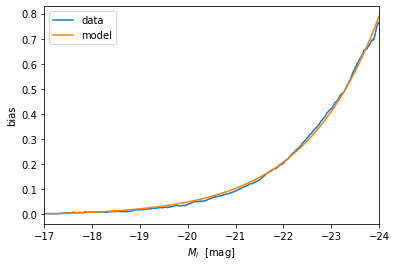

In [291]:
myDF = pd.read_csv("Bias_Malmquist_i.csv")

myDF.plot(x="Mag_i", y="Bias", label='data')



########################################################
def myF(M, alpha, beta):
    
    X = -17-M

    
    return beta*(np.exp(X**alpha)-1)



x = np.linspace(-24, -17, 1000)

fit, cov = curve_fit(myF, Mag, Bias)
print(fit)

print(np.sqrt(cov))

y = myF(x, fit[0], fit[1])
# y = myF(x, 0.908, 0.00115)

plt.plot(x,y, label='model')

# plt.plot(x, 0.004*(-x-17)**2.3, 'r-')


plt.xlim(-17,-24)

plt.ylabel("bias")
plt.xlabel(r"$M_i$"+"  [mag]")

plt.legend()

In [285]:
myTable = Table()

myTable.add_column(Column(data=Mag, name="Mag_i", format='%0.4f')) 
myTable.add_column(Column(data=Bias, name="Bias", format='%0.4f')) 
myTable.write('Bias_Malmquist_i.bar', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)